In [13]:
import torch 
import numpy as np
from torchvision.io import read_video
import tensorly
from tqdm.auto import tqdm
from itertools import product
from hottbox.core import Tensor
from hottbox.algorithms.decomposition import TTSVD, HOSVD, HOOI, CPD
from hottbox.metrics import residual_rel_error
from copy import deepcopy
from matplotlib import pyplot as plt
from torchvision.io import write_video

In [14]:
dataset_path = "ColoredMovingMNIST/videos.npy"

In [15]:
data = np.load("ColoredMovingMNIST/videos.npy")
data.shape

(20, 20, 3, 40, 40)

In [17]:
for i in range(len(data)):
    write_video(f"./videos/{i}.mp4", data[i].transpose(0,3,2,1), fps=5)

In [18]:
def calculate_HOSVD(data, alg=HOSVD(), t_sizes=[], hw_sizes=[], c_sizes=[]):
    res_dicts = []
    for elem in tqdm(data):

        tensor = Tensor((elem/255).astype(np.float64).transpose(0,2,3,1))
        
        ml_ranks_t_hw_c = product(t_sizes, hw_sizes, c_sizes)
        res_dict = {}
        
        for ml_rank_t_hw_c in tqdm(ml_ranks_t_hw_c, colour="#4444BB"):
            ml_rank = (ml_rank_t_hw_c[0], ml_rank_t_hw_c[1], ml_rank_t_hw_c[1], ml_rank_t_hw_c[2])
    
            decomposed = alg.decompose(tensor, ml_rank)
    
            size = np.prod(ml_rank)
            
            for fmat in decomposed.fmat:
                size += np.prod(fmat.shape)
    
            error = residual_rel_error(tensor, decomposed)
            compression = size / np.prod(tensor.shape)
    
            res_dict[ml_rank_t_hw_c] = {
                "error": error,
                "compression": compression,
                "decomposed": deepcopy(decomposed)
            }
    
        res_dicts.append(res_dict)
        
    return res_dicts

In [19]:
def restore_from_decomposition(decomposed):
    restored = np.einsum("ijkl,mi,nj,ok,pl->mnop", decomposed.core.data, 
                                                   decomposed.fmat[0],
                                                   decomposed.fmat[1],
                                                   decomposed.fmat[2],
                                                   decomposed.fmat[3])
    return np.array(restored.clip(0, 1) * 255).astype(np.uint8)

In [68]:
def plot_comparison(original, restored, frame, title_add=""):
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    
    axes[0].imshow(original[frame].transpose(2,1,0))
    axes[1].imshow(restored[frame].transpose(1,0,2))

    axes[0].set_title("Original", fontsize=18)
    axes[1].set_title("Restored" + title_add, fontsize=18)

    
    plt.show()

In [77]:
def restore_and_show(original, decomposed, frame, title_add=""):
    restored = restore_from_decomposition(decomposed)
    plot_comparison(original, restored, frame, title_add=title_add)

In [22]:
decomposed_data = calculate_HOSVD(data=data,
                                  t_sizes=[1, 5, 10, 20], 
                                  hw_sizes=[5, 10, 20, 40], 
                                  c_sizes=[1, 2, 3])

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [23]:
restored0 = restore_from_decomposition(decomposed_data[0][(10, 20, 2)]["decomposed"])

In [44]:
restored1 = restore_from_decomposition(decomposed_data[1][(10, 20, 2)]["decomposed"])

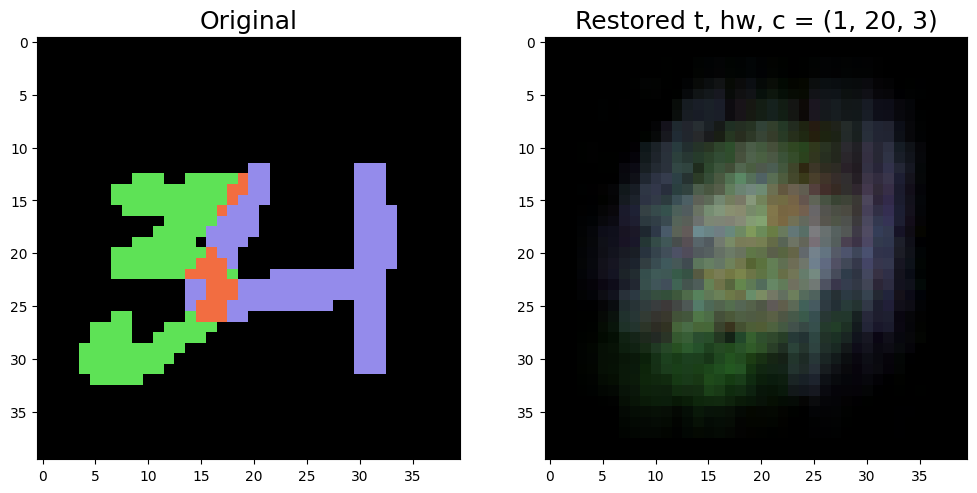

In [83]:
restore_and_show(data[0], decomposed_data[0][(1, 20, 3)]["decomposed"], 15, title_add=" t, hw, c = (1, 20, 3)")

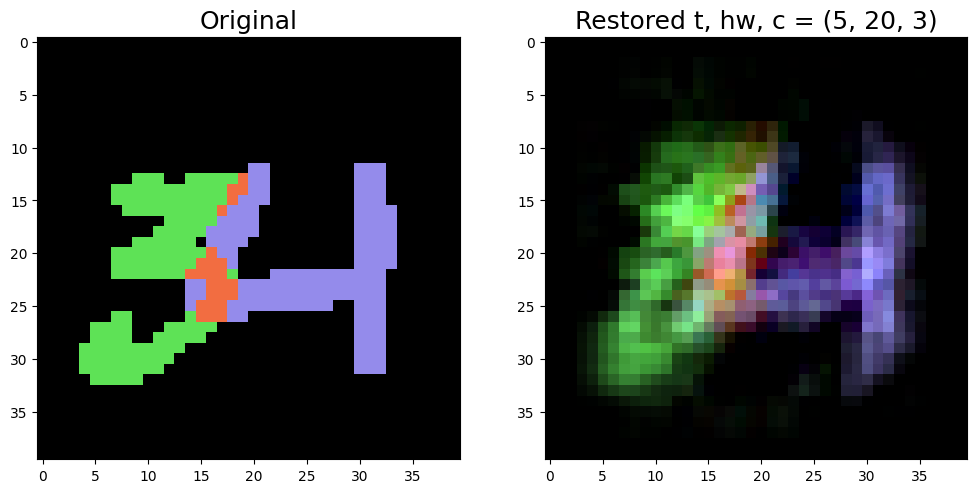

In [84]:
restore_and_show(data[0], decomposed_data[0][(5, 20, 3)]["decomposed"], 15, title_add=" t, hw, c = (5, 20, 3)")

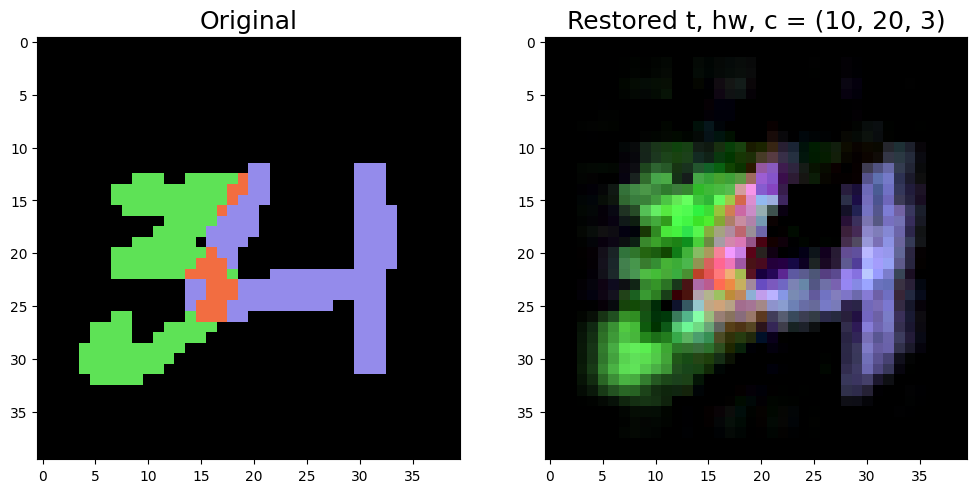

In [85]:
restore_and_show(data[0], decomposed_data[0][(10, 20, 3)]["decomposed"], 15, title_add=" t, hw, c = (10, 20, 3)")

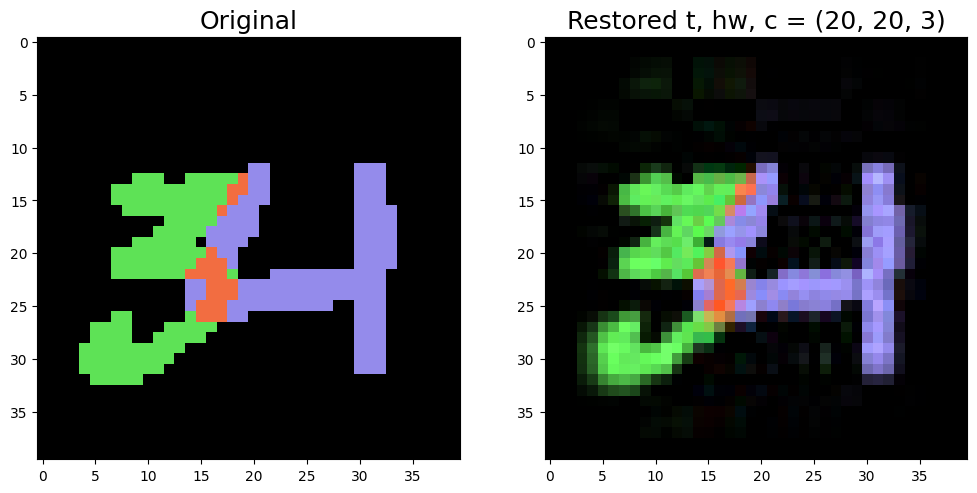

In [86]:
restore_and_show(data[0], decomposed_data[0][(20, 20, 3)]["decomposed"], 15, title_add=" t, hw, c = (20, 20, 3)")

In [91]:
restored0_5_20_3 = restore_from_decomposition(decomposed_data[0][(5, 20, 3)]["decomposed"])
restored0_10_20_3 = restore_from_decomposition(decomposed_data[0][(10, 20, 3)]["decomposed"])
restored0_20_20_3 = restore_from_decomposition(decomposed_data[0][(20, 20, 3)]["decomposed"])

In [96]:
restored0_5_20_3.shape

(20, 40, 40, 3)

In [97]:
write_video(f"./videos/0_restored0_5_20_3.mp4", restored0_5_20_3.transpose(0,2,1,3), fps=5)

In [98]:
write_video(f"./videos/0_restored0_10_20_3.mp4", restored0_10_20_3.transpose(0,2,1,3), fps=5)

In [99]:
write_video(f"./videos/0_restored0_20_20_3.mp4", restored0_20_20_3.transpose(0,2,1,3), fps=5)

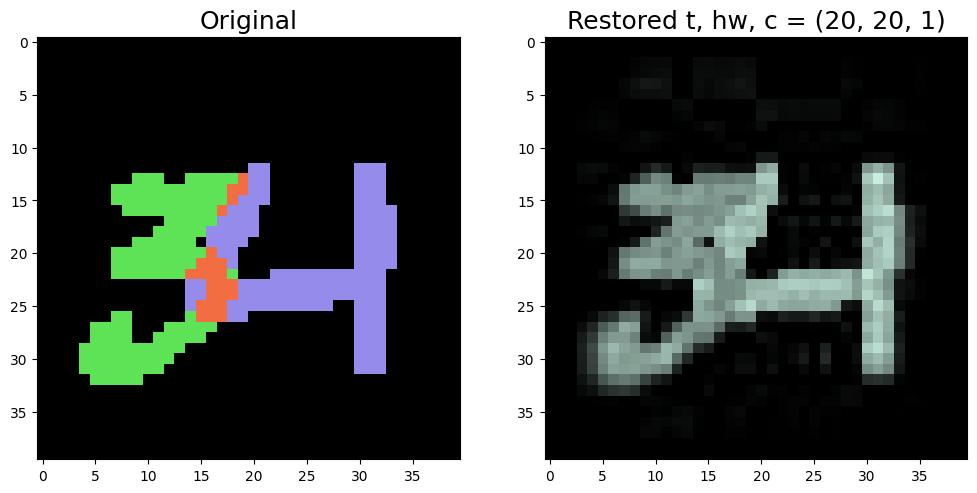

In [87]:
restore_and_show(data[0], decomposed_data[0][(20, 20, 1)]["decomposed"], 15, title_add=" t, hw, c = (20, 20, 1)")

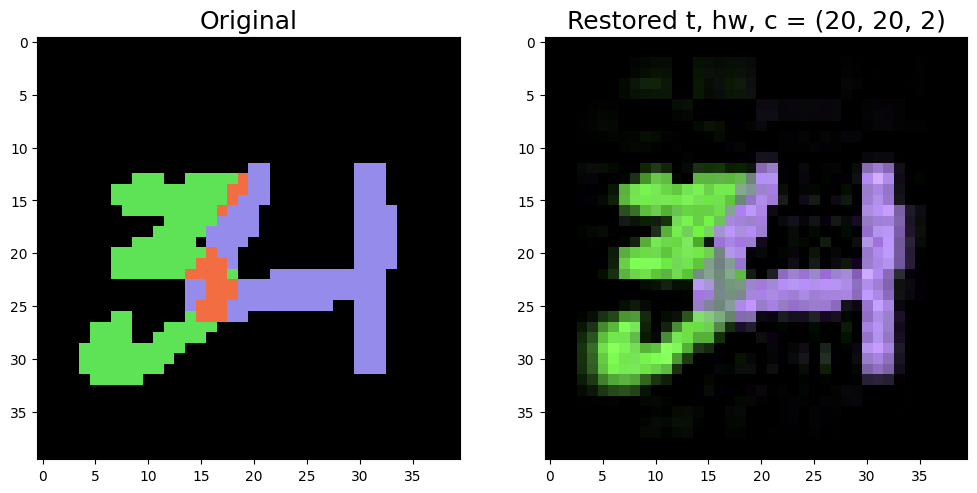

In [88]:
restore_and_show(data[0], decomposed_data[0][(20, 20, 2)]["decomposed"], 15, title_add=" t, hw, c = (20, 20, 2)")

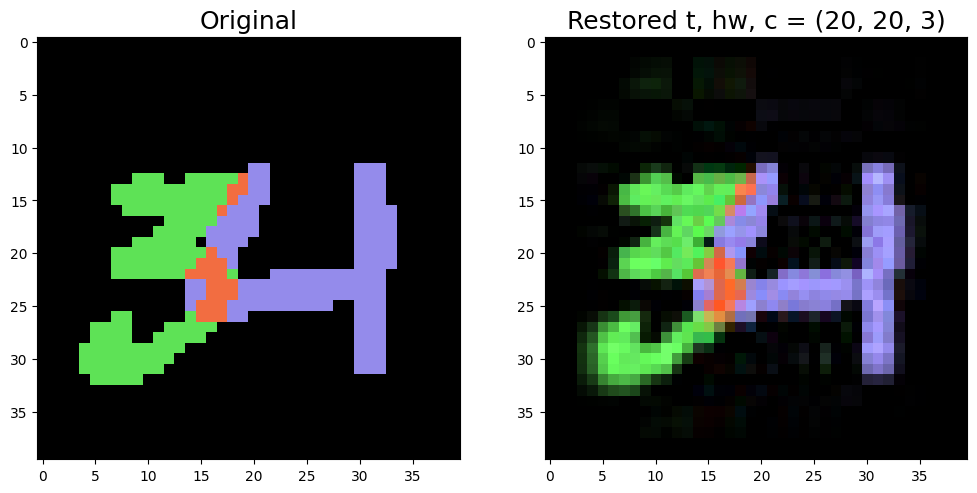

In [89]:
restore_and_show(data[0], decomposed_data[0][(20, 20, 3)]["decomposed"], 15, title_add=" t, hw, c = (20, 20, 3)")

In [100]:
restored0_20_20_1 = restore_from_decomposition(decomposed_data[0][(20, 20, 1)]["decomposed"])
restored0_20_20_2 = restore_from_decomposition(decomposed_data[0][(20, 20, 2)]["decomposed"])

In [113]:
write_video(f"./videos/0_restored0_20_20_1.mp4", restored0_20_20_1.transpose(0,2,1,3), fps=5)
write_video(f"./videos/0_restored0_20_20_2.mp4", restored0_20_20_2.transpose(0,2,1,3), fps=5)

In [101]:
data[0].shape

(20, 3, 40, 40)

In [110]:
data0_grayscale_manually = torch.tensor(data[0].mean(1).astype(np.uint8)).repeat(3, 1, 1, 1).permute(1,3,2,0)
data0_grayscale_manually.shape

torch.Size([20, 40, 40, 3])

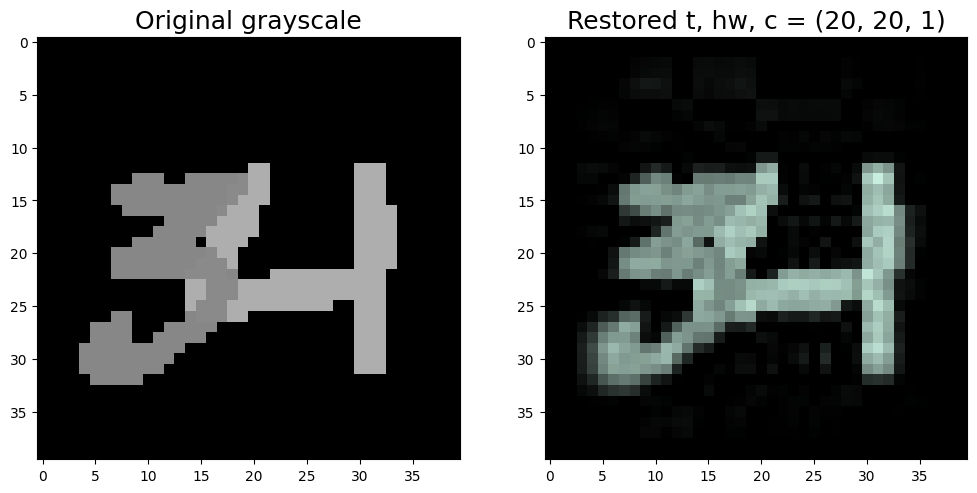

In [112]:
frame = 15

fig, axes = plt.subplots(1, 2, figsize=(12,6))
    
axes[0].imshow(data0_grayscale_manually[frame])
axes[1].imshow(restored0_20_20_1[frame].transpose(1,0,2))

axes[0].set_title("Original grayscale", fontsize=18)
axes[1].set_title("Restored t, hw, c = (20, 20, 1)", fontsize=18)

plt.show()

In [111]:
write_video(f"./videos/data0_grayscale_manually.mp4", data0_grayscale_manually, fps=5)

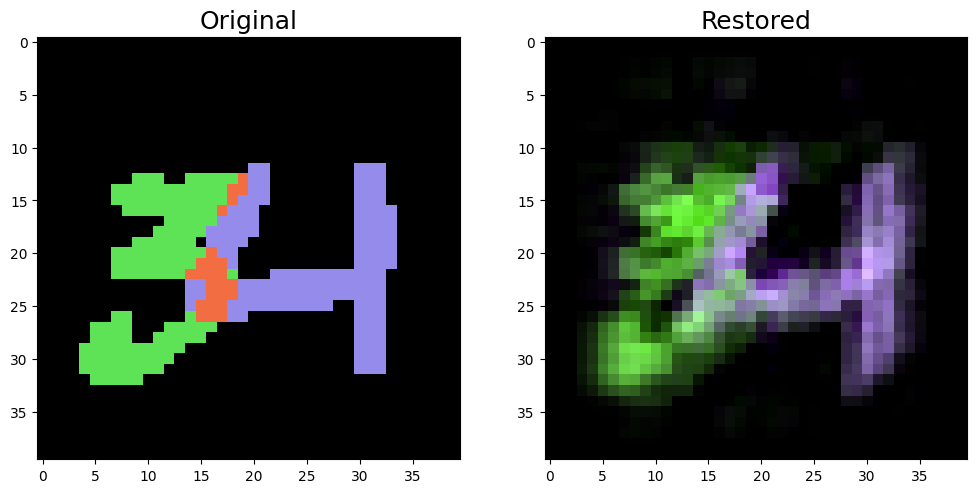

In [43]:
plot_comparison(data[0], restored0, 15)

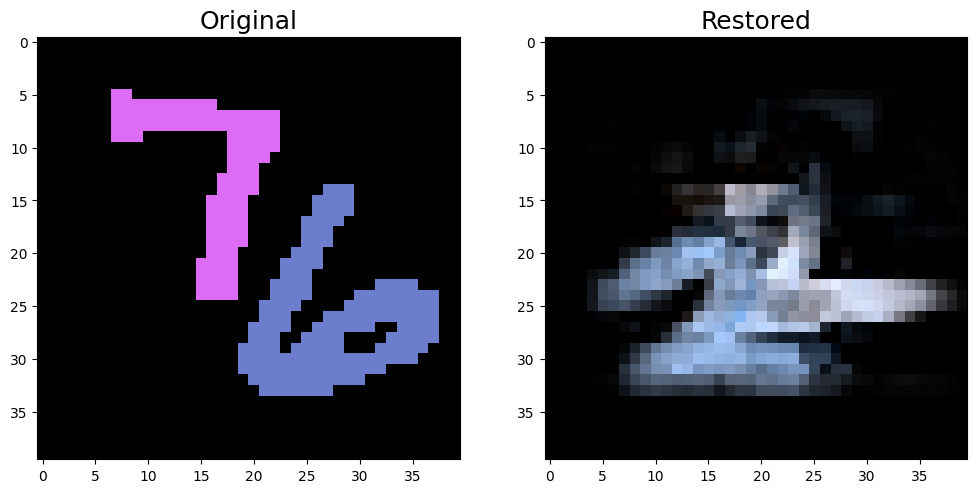

In [67]:
plot_comparison(data[16], restored1, 4)

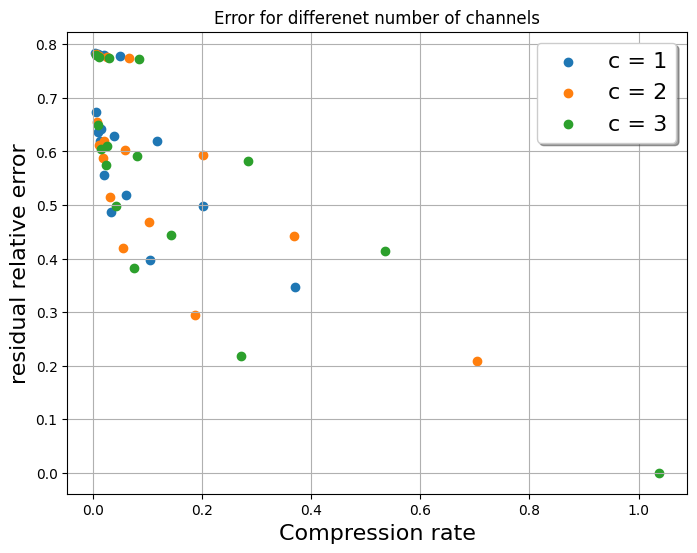

In [70]:
errors1 = []
errors2 = []
errors3 = []
compression1 = []
compression2 = []
compression3 = []


for k, v in decomposed_data[0].items():
    if k[-1] == 1:
        errors1.append(v["error"])
        compression1.append(v["compression"])
    elif k[-1] == 2:
        errors2.append(v["error"])
        compression2.append(v["compression"])
    elif k[-1] == 3:
        errors3.append(v["error"])
        compression3.append(v["compression"])


plt.figure(figsize=(8, 6))

plt.scatter(compression1, errors1, label="c = 1")
plt.scatter(compression2, errors2, label="c = 2")
plt.scatter(compression3, errors3, label="c = 3")
plt.legend(shadow=True, fontsize=16)
plt.xlabel("Compression rate", fontsize=16)
plt.ylabel("residual relative error", fontsize=16)
plt.grid()
plt.title("Error for differenet number of channels")
plt.show()

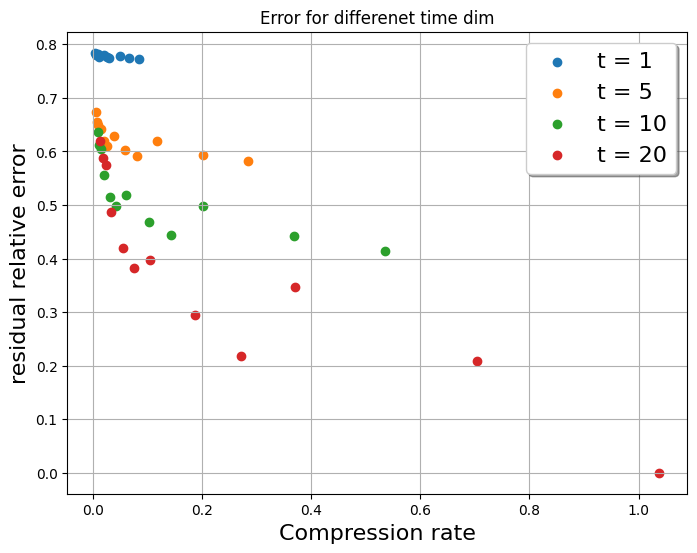

In [90]:
errors1 = []
errors5 = []
errors10 = []
errors20 = []
compression1 = []
compression5 = []
compression10 = []
compression20 = []


for k, v in decomposed_data[0].items():
    if k[0] == 1:
        errors1.append(v["error"])
        compression1.append(v["compression"])
    elif k[0] == 5:
        errors5.append(v["error"])
        compression5.append(v["compression"])
    elif k[0] == 10:
        errors10.append(v["error"])
        compression10.append(v["compression"])
    elif k[0] == 20:
        errors20.append(v["error"])
        compression20.append(v["compression"])


plt.figure(figsize=(8, 6))

plt.scatter(compression1, errors1, label="t = 1")
plt.scatter(compression5, errors5, label="t = 5")
plt.scatter(compression10, errors10, label="t = 10")
plt.scatter(compression20, errors20, label="t = 20")
plt.xlabel("Compression rate", fontsize=16)
plt.ylabel("residual relative error", fontsize=16)
plt.legend(shadow=True, fontsize=16)
plt.title("Error for differenet time dim")
plt.grid()
plt.show()

In [211]:
restored = np.einsum("ijkl,mi,nj,ok,pl->mnop", video0_hosvd.core.data, 
                                               video0_hosvd.fmat[0],
                                               video0_hosvd.fmat[1],
                                               video0_hosvd.fmat[2],
                                               video0_hosvd.fmat[3])

In [212]:
restored.max(), restored.min()

(0.9764679839827736, -7.625844400394044e-15)

In [213]:
restored_array = np.array(restored.clip(0, 1) * 255).astype(np.uint8)

In [214]:
restored_array.shape

(20, 40, 40, 3)

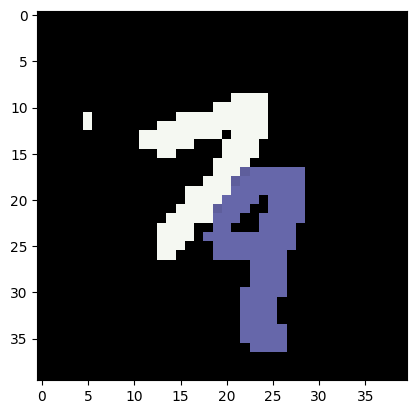

In [215]:
plt.imshow(restored_array[0].transpose(1,0,2))

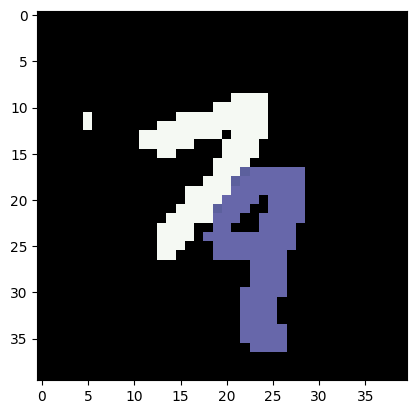

In [216]:
plt.imshow(data[0][0].transpose(2,1,0))